# The dataset is a sale one

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/Users/philippebeliveau/Desktop/Bureau/Notebook_Jupyter_R/datah-m1-challange/sales.csv")

In [9]:
df.head()

,DATE,S100,I100,C100,C101,QTT
0,2017-01-08,0,0,12,76,2
1,2017-01-08,0,0,12,149,3
2,2017-01-08,0,0,12,256,3
3,2017-01-08,0,0,12,354,3
4,2017-01-08,0,0,13,149,2


In [10]:
df.shape[0]

2749369

Starts in 2017 and end in 2021

<function matplotlib.pyplot.show(close=None, block=None)>

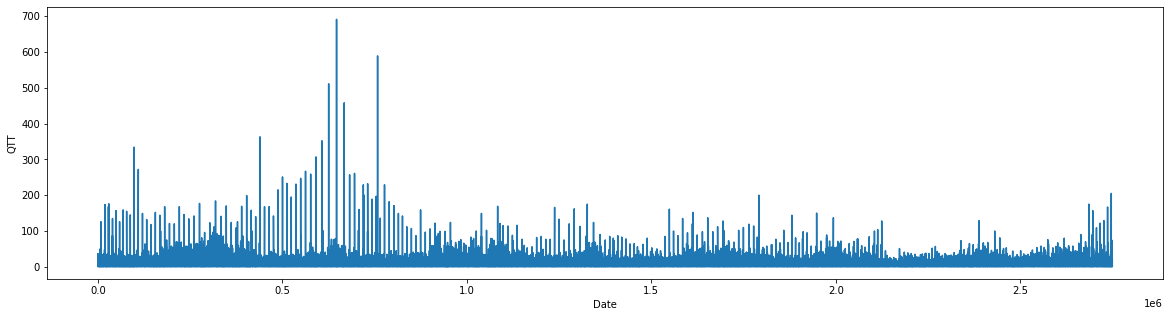

In [51]:
plt.figure(figsize=(20,5))
plt.plot(df["QTT"])

plt.xlabel("Date")
plt.ylabel("QTT")
plt.show

## Number of zeros

In [6]:
df.eq(0).sum()

DATE        0
S100    99850
I100     8841
C100     6601
C101       89
QTT         0
dtype: int64

## Transformation
We can use pyFTS own transformations tool. Although, I am not sure how are we going to integrate our own transformation in the partionning function.

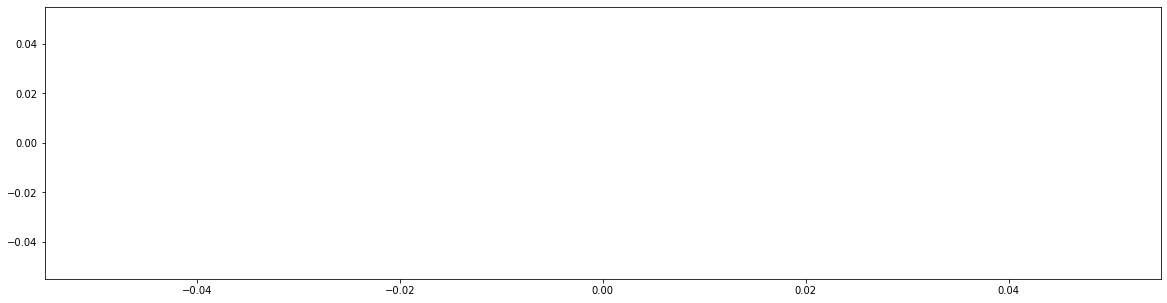

In [46]:
from pyFTS.common import Transformations

diff = Transformations.Differential(1)
fig = plt.subplots(figsize=(20,5))
plt.plot(diff.apply(uni_train), label="QTT")
pass

# Train test split
Only the training data seems to be partionned. 

In [120]:
train = df.iloc[:2000000]
test = df.iloc[2000001:2749369]

uni_train = train["QTT"]
multi_train = train

uni_test = test['QTT']
multi_test = test

# Training phase

## Step 1 - Universe of Discourse partitioning: 
partitioning is the most significant part of training phase. It is applied
to split the Universe of Discourse U into fuzzy sets by making linguistic values A˜ through various types of
available techniques in the literature.

In [61]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership as mf
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.data import Enrollments

#### Data partitioning
Creation of A˜ (partitions) strongly depends on three hyperparameters: the number of partitions, the partitioning
techniques and membership function µ.

#### Partioning technique
The partitioning methods are commonly divided into two groups according to the length or size of intervals: fixed (equal)
intervals and unequal interval techniques as illustrated in Figure 2.
In an equal-sized partitioning technique the length of generated fuzzy sets are equal. Due to its main advantages, which are
simplicity and not being time consuming, it has been adopted by numerous scientists [13–27]. Grid partitioning proposed in [8]
is known as the simplest partitioning scheme. Considering k as the number of intervals, then in Grid partitioning method, k fuzzy
sets with the same size will be created by splitting U into k overlapping fuzzy sets. Some works in the literature used simple
heuristic partitioning methods, including [28–32].

#### The Number of Partitions k
Another parameter that has a strong effect on the accuracy of the model is the number of fuzzy sets. Choosing a large value for k increases the complexity of the model because too many
fuzzy sets and rules are generated, perhaps more than the required number. This factor has effect on the readability and explainability of the model [83].

#### The Membership Function
The membership function specifies the degree in [0, 1] to which a crisp value belongs to a fuzzy set. Although the influence on
the accuracy is less important than other parameters, it is recommended to test different fuzzy sets in the model. Trapezoidal,
Triangular and Gaussian are the most common ones. 

#### Parameters 
data: the time series training data;
* npart: the minimum number of partitions/fuzzy sets;
* mf: the membership function that will be used, which by default is triangular (trimf). The various membership
functions can be found in pyFTS.common.Membership;
* transformation: if any transformation is used in the series, it must be informed.

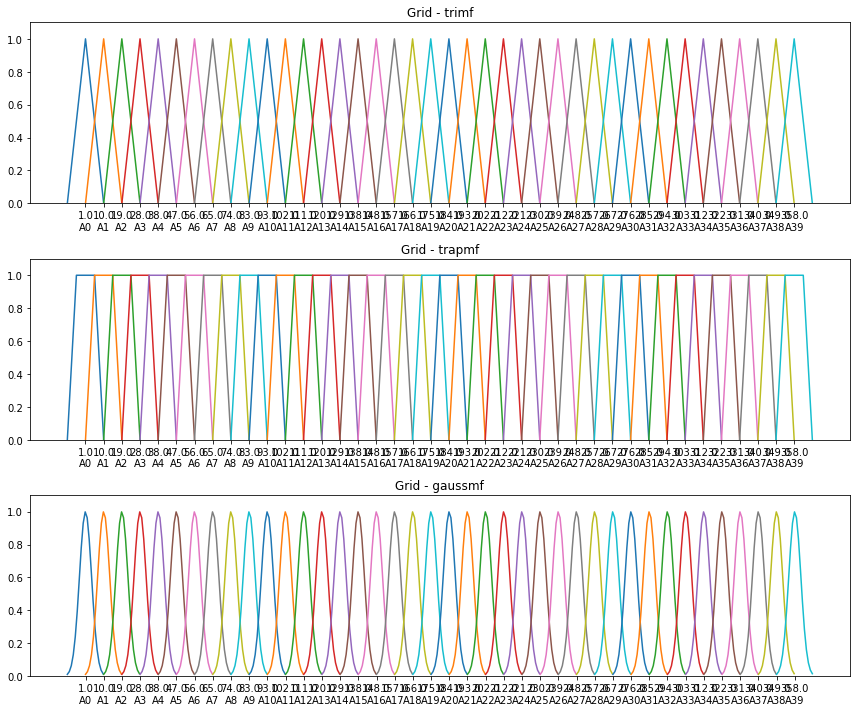

In [63]:
part = pUtil.explore_partitioners(uni_train, 40, methods=[Grid.GridPartitioner], 
                                  mf=[mf.trimf, mf.trapmf, mf.gaussmf])

/opt/anaconda3/envs/Fuzzy_TS/lib/python3.6/site-packages/pyFTS/partitioners/partitioner.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


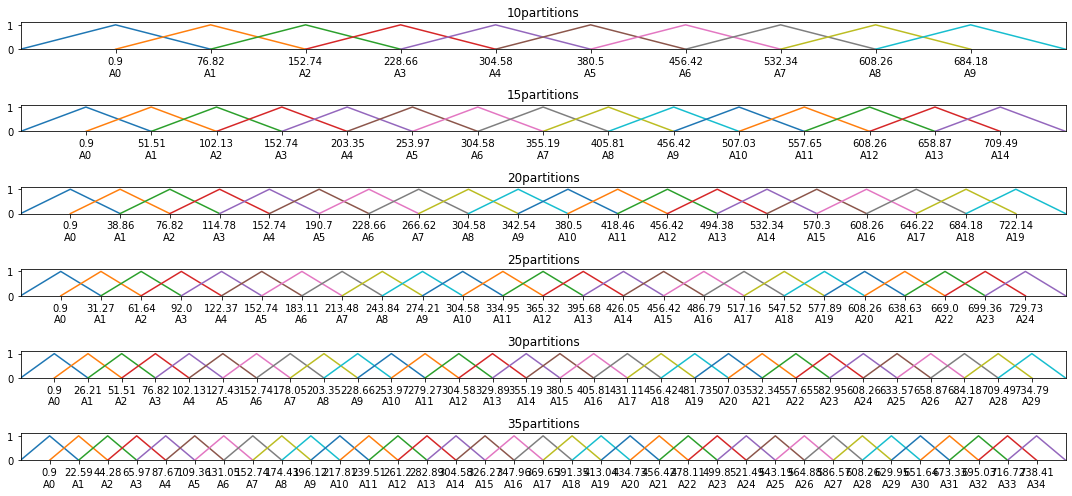

In [121]:
fig, ax = plt.subplots(nrows=6, ncols=1,figsize=[15,7])

for ct, npart in enumerate(np.arange(10,40, 5)):
  part = Grid.GridPartitioner(data=uni_train, npart=npart, mf=[mf.gaussmf])#transformation=diff
  part.name = str(npart) + "partitions"
  
  part.plot(ax[ct], rounding=2)
 
plt.tight_layout()

In [123]:
parts = Grid.GridPartitioner(data=uni_train, npart=15)

#### Potential improvement
Different types of mathematical partitioning methods exist such as Distribution-based and average-based partitioning [34], Heuristic information [28] based on Chen’s
model, frequency-density-based partitions [35], automatic clustering developed in [36] due to the maximum data difference and
initializing the number of cluster by one. 

#### Question 
- How to assess for the best number of partitions?

## Step 2 - Fuzzification: 
in this step the numeric data Y is converted into linguistic variables A˜ via given partitioning
method with regards to their memberships degrees to the fuzzy sets. The obtained linguistic or fuzzified version
of y(t) ∈ Y , represents the fuzzy time series F in which f(t) ∈ F are fuzzy values.

### Question 
What is the effect of the number of partitions on the fuzzification process?

In [124]:
from pyFTS.common import FuzzySet as fz
F = fz.fuzzyfy_series(uni_train, parts.sets)
print(F)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



I feel like Fuzzy sets are not good when dealing with zeros.

## Step 3 - Knowledge or Temporal Pattern Extraction:
This step focuses mainly on extracting knowledge from F due
to the past observations or lags. In other words, this stage analyzes the sequential terms in F, grouping the
patterns in rules (Ai) → (Aj ),(Ak), . . . and can be said that if f(t) is (Ai) then f(t + 1) is (Aj ),(Ak), . . ..
For example, in Figure 1, A4 and A3 generate the fuzzy logical rule (FLR) A4 → A3 which is then grouped
into the GFLR A4 → A4, A5, A3.

Feed forward neural network can be used to determine fuzzy relations. 

### Generate the rules

In [125]:
from pyFTS.common import FLR
rules = FLR.generate_non_recurrent_flrs(F)
print([str(k) for k in rules[0:10]])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A0 -> A2', 'A2 -> A0', 'A2 -> A2', 'A1 -> A1', 'A2 -> A3', 'A3 -> A0', 'A1 -> A3']


### Make the grouping of the rules
Dont forget to transform the data into .values

#### Order is the number of precedent that is use to predict yt+1 
I believe it is a parameter that you can tune

In [126]:
from pyFTS.models import chen
for order in [2,3]:
    model = chen.ConventionalFTS(partitioner=parts, order=order)
    model.name= model +str(order)
    model.fit(uni_train.values, order=1)
    print(model)

Conventional FTS:
A14 -> A0
A9 -> A0
A12 -> A0
A7 -> A0,A1
A5 -> A0,A1
A10 -> A1
A1 -> A0,A1,A2,A3,A4,A5
A2 -> A0,A1,A2,A3,A4,A5,A7
A3 -> A0,A1,A2,A3,A4,A5,A6,A7
A0 -> A0,A1,A12,A2,A3,A4,A5,A7
A4 -> A0,A1,A10,A3,A5,A6,A9
A6 -> A0,A14



chen.conventionalFTS : https://www.researchgate.net/publication/220231471_Forecasting_Enrollments_Based_on_High-Order_Fuzzy_Time_Series

# Forecasting procedure

## Step 1 - Fuzzification: 
the fuzzification step is the same for both forecasting process and training procedure. It means
that it translates the numeric sample y(t) ∈ Y into a fuzzy value f(t), where f(t) ∈ A˜.

In [127]:
from pyFTS.common import FuzzySet as fz
f = fz.get_maximum_membership_fuzzyset(uni_train.values, parts.sets)
print(f)

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('bool') with casting rule 'same_kind'

## Step 2 - Defuzzification: 
now it is necessary to convert f(t + 1) to a numerical value. The predict method uses the already
trained model to make predictions. There are three possible forecast types, indicated by the ’type’ parameter: ’point’
(default), ’interval’ and ’distribution’. Read about the model used, as not all of them work with all forecast types.
Finally, the ’steps ahead’ parameter indicates the forecast horizon, or how many steps ahead you want to forecast.

In [ ]:
plt.plot(uni_test)

In [130]:
forecasts = model.predict(uni_test.values, type='point', steps_ahead=1)

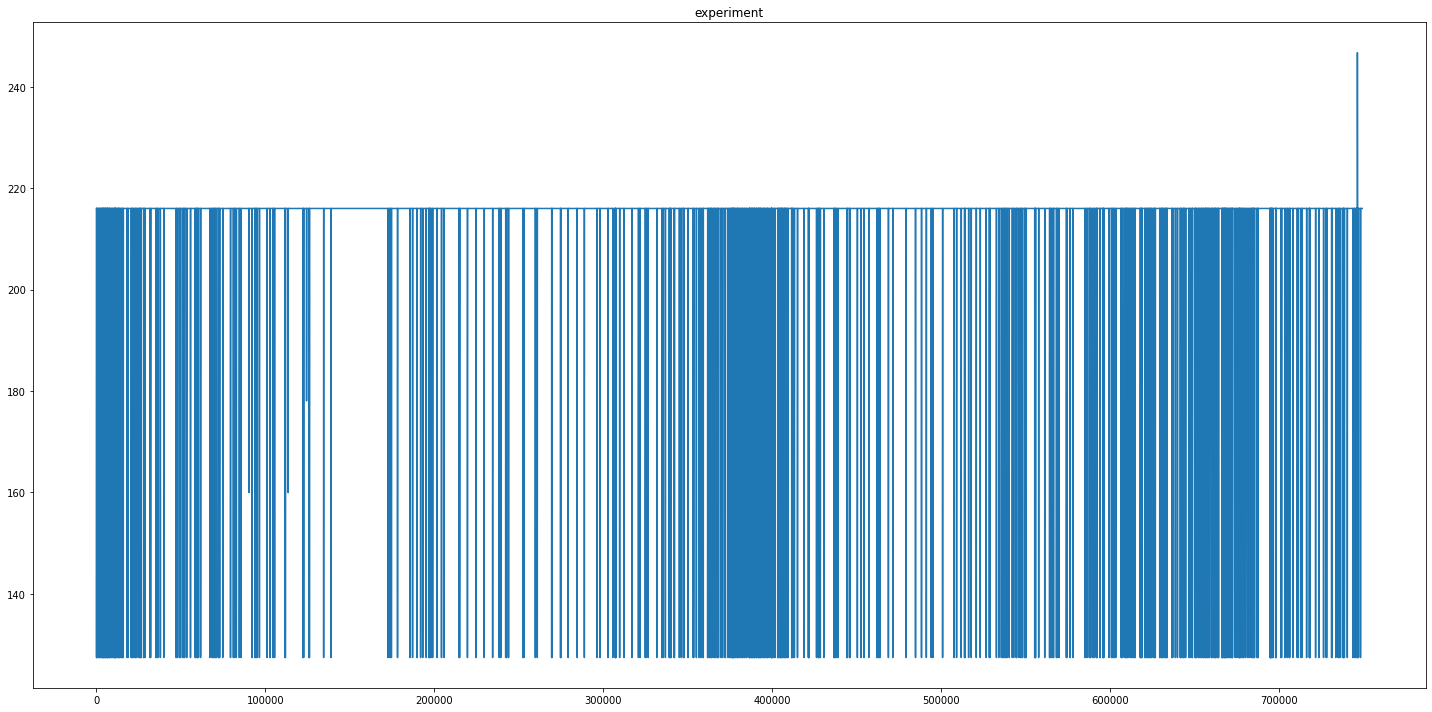

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[30,10])
ax.plot(forecasts)
ax.set_title("experiment")
    
plt.tight_layout()

In [135]:
measures = Measures.get_point_statistics(uni_test.values, model)
m = np.reshape(measures, (1, 3))

In [141]:
pd.DataFrame(m,columns=["RMSE","SMAPE","Theil's U"])

,RMSE,SMAPE,Theil's U
0,213.51,14596.11,62.64
